# ===========================================================
# NAME: EMMANUEL INEGET
# COURSE NAME: DATA ANALYSIS AND PROCESS MINING 
# COURSE CODE: DSC8204
# COURSE FACILITATOR(S):  DR. DAPHINE NYACHAKI BITALO
# EXAM TYPE: PROJECT-BASED EXAM

# PART A - Goal 2: Natural Language Processing in the Law [30 Marks]

1. Language Data Summary:  
    - a. Data source: Mine for any two judgements from the Uganda Legal Information Institute (ULII) website (https://ulii.org/judgments/) passed in the last 5 years.

In [1]:
# # Note: Some of the Libraries are already installed. I shall now start by installing some of the additional libraries that i shall need to accomplish the task.
# !pip install requests
# !pip install beautifulsoup4
# !pip install nltk
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install sumy

In [14]:
# Download NLTK resources (run once)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

# %pip install requests beautifulsoup4 nltk transformers torch 

# %pip install sumy pandas seaborn wordcloud matplotlib

In [8]:
# I shall now import the necessary libraries
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from transformers import pipeline

import pandas as pd
import numpy as np

import csv
from nltk.tokenize import sent_tokenize
import torch

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [9]:
# List of judgment URLs to scrape
judgment_urls = [
    "https://ulii.org/akn/ug/judgment/ugcommc/2024/347/eng@2024-12-31",
    "https://ulii.org/akn/ug/judgment/ugcommc/2024/346/eng@2024-12-31"
]

# CSV filename
csv_filename = "ulii_judgments_metadata.csv"

# Define CSV headers
headers = ["Citation", "Media Neutral Citation", "Court", "Case Number", "Judges", 
           "Judgment Date", "Language", "Type", "Flynote", "Case Summary", "Order", "Judgment Link"]

# Function to extract text 
def get_text(element):
    return element.text.strip() if element else "N/A"

# Function to scrape metadata from a judgment page
def scrape_judgment_metadata(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to access {url}")
        return None
    
    soup = BeautifulSoup(response.content, "html.parser")

    # Extract metadata using relevant tags
    citation = get_text(soup.find("dd", class_="text-muted"))
    media_citation = get_text(soup.find_all("dd", class_="text-muted")[1])  # Second occurrence
    court = get_text(soup.find("a", href="/judgments/UGCommC/"))
    case_number = get_text(soup.find_all("dd", class_="text-muted")[3])  # Case number index
    judges = get_text(soup.find_all("dd", class_="text-muted")[4])  # Judges index
    judgment_date = get_text(soup.find_all("dd", class_="text-muted")[5])  # Judgment date index
    language = get_text(soup.find_all("dd", class_="text-muted")[6])  # Language index
    judgment_type = get_text(soup.find_all("dd", class_="text-muted")[7])  # Type index
    
    checker = soup.find("dl", class_="document-metadata-list d-md-flex").find_all("dt")
    case_summary = "N/A"
    flynote = "N/A"
    order = "N/A"
    for row in checker:
        match row.text.strip():
            case "Flynote":
                flynote = row.find_next_sibling("dd").text.strip() 
                
            case "Case summary":
                case_summary = row.find_next_sibling("dd").text.strip()
                
            case "Order":
                order = row.find_next_sibling("dd").text.strip()

    return [citation, media_citation, court, case_number, judges, judgment_date, language, 
            judgment_type, flynote, case_summary, order, url]

# Scrape all judgments and store data
collected_data = []
for url in judgment_urls:
    metadata = scrape_judgment_metadata(url)
    if metadata:
        collected_data.append(metadata)

# Save extracted metadata to CSV
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(collected_data)

print(f"Metadata successfully saved to {csv_filename}")


Metadata successfully saved to ulii_judgments_metadata.csv


- b. Using the appropriate NLP tools, summarize the judgements passed in the legal cases above. 

In [10]:
legal_case_data = pd.read_csv('ulii_judgments_metadata.csv')
legal_case_data.head()

,Citation,Media Neutral Citation,Court,Case Number,Judges,Judgment Date,Language,Type,Flynote,Case Summary,Order,Judgment Link
0,Majari Investments Limited v Betimo General Su...,[2024] UGCommC 347\n \n\n \n Copy,Commercial Court of Uganda,Civil Suit 562 of 2020,"Mutesi, J",31 December 2024,English,Judgment,Contracts—writing requirement—money had and re...,"The Plaintiff sought recovery of USD 154,929, ...",NaN,https://ulii.org/akn/ug/judgment/ugcommc/2024/...
1,Mukamuriza v Karugaba & 2 Others (Civil Suit 5...,[2024] UGCommC 346\n \n\n \n Copy,Commercial Court of Uganda,Civil Suit 554 of 2020,"Mutesi, J",31 December 2024,English,Judgment,Land—ownership disputes—proof of purchase—burd...,The Plaintiff sought ownership of land she cla...,NaN,https://ulii.org/akn/ug/judgment/ugcommc/2024/...


In [11]:
legal_case_data.columns

Index(['Citation', 'Media Neutral Citation', 'Court', 'Case Number', 'Judges',
       'Judgment Date', 'Language', 'Type', 'Flynote', 'Case Summary', 'Order',
       'Judgment Link'],
      dtype='object')

In [12]:
# Identify Relevant Column for Judgments
legal_case_data[['Case Summary', 'Flynote', 'Citation']].head()

,Case Summary,Flynote,Citation
0,"The Plaintiff sought recovery of USD 154,929, ...",Contracts—writing requirement—money had and re...,Majari Investments Limited v Betimo General Su...
1,The Plaintiff sought ownership of land she cla...,Land—ownership disputes—proof of purchase—burd...,Mukamuriza v Karugaba & 2 Others (Civil Suit 5...


In [15]:
# Initialize summarization model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Define a function to summarize text
def summarize_text(text):
    if pd.isna(text) or len(text.split()) < 30:  # Skip short/missing summaries
        return text
    return summarizer(text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']

# Apply summarization to each record in the 'Case Summary' column
legal_case_data['Abstractive Summary'] = legal_case_data['Case Summary'].apply(summarize_text)

# Save results to a new CSV file
legal_case_data.to_csv('summarized_judgments.csv', index=False)

# Display first few rows to verify
# print(legal_case_data[['Case Summary', 'Abstractive Summary']].head())

Device set to use cpu


In [16]:
legal_case_data[['Case Summary', 'Abstractive Summary']]

,Case Summary,Abstractive Summary
0,"The Plaintiff sought recovery of USD 154,929, ...","The Plaintiff sought recovery of USD 154,929, ..."
1,The Plaintiff sought ownership of land she cla...,The Plaintiff sought ownership of land she cla...


In [55]:
import textwrap

wrapped_summary1 = textwrap.fill(legal_case_data['Abstractive Summary'][0], width=80)
wrapped_summary2 = textwrap.fill(legal_case_data['Abstractive Summary'][1], width=80)
print(f'Abstractive summary 1:\n{wrapped_summary1}\n\n Abstractive summary 2:\n{wrapped_summary2} ')

Abstractive summary 1:
The Plaintiff sought recovery of USD 154,929, alleging the Defendants requested
funds for a consignment of wine. The Defendants denied the claims, citing no
written contract and disputing the alleged arrangement. The Court held that the
Plaintiff's claim was based on equitable restitution and unjust enrichment, not
enforcement of a written contract.

 Abstractive summary 2:
The Plaintiff sought ownership of land she claimed to have purchased through her
then-fiancé, the 1st Defendant. The Court found no evidence substantiating her
claim, including the absence of a sale agreement. 


In [19]:
# Initialize LexRank summarizer
summarizer = LexRankSummarizer()

In [20]:
# function to summarize all case summaries.
def extractive_summary(text, num_sentences=3):
    """Extracts the most important sentences from the text."""
    if isinstance(text, str) and len(text.split()) > 30: # Check if text is not empty
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summary = summarizer(parser.document, num_sentences)
        return " ".join(str(sentence) for sentence in summary)
    return text  


In [48]:
# Original judgment texts
case_1 = legal_case_data['Case Summary'
''][0]

case_2 = legal_case_data['Case Summary'
''][1]

# Generate summaries
summary_1 = extractive_summary(case_1, num_sentences=3)
summary_2 = extractive_summary(case_2, num_sentences=3)


In [49]:

# Store results in DataFrame
df_summaries = pd.DataFrame({
    "Case Number": ["Case 1", "Case 2"],
    "Original Judgment": [case_1, case_2],
    "Summarized Judgment": [summary_1, summary_2]})
# Save to CSV
df_summaries.to_csv("summarized_judgments.csv", index=False)

print("Summarized judgments saved as 'summarized_judgments.csv'.")

Summarized judgments saved as 'summarized_judgments.csv'.


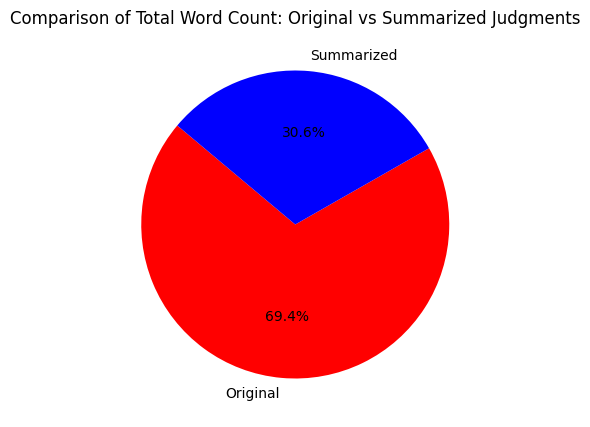

In [53]:
df_summaries["Original Length"] = df_summaries["Original Judgment"].apply(lambda x: len(x.split()))
df_summaries["Summarized Length"] = df_summaries["Summarized Judgment"].apply(lambda x: len(x.split()))

# Calculate total lengths
total_original_length = df_summaries["Original Length"].sum()
total_summarized_length = df_summaries["Summarized Length"].sum()

# Data for pie chart
lengths = [total_original_length, total_summarized_length]
labels = ['Original', 'Summarized']
colors = ['red', 'blue']

plt.figure(figsize=(8, 5))
plt.pie(lengths, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Comparison of Total Word Count: Original vs Summarized Judgments")
plt.show()

In [52]:
legal_case_data.to_csv("summarized_judgments.csv", index=False)
print("Summarization complete! File saved as summarized_judgments.csv.")


Summarization complete! File saved as summarized_judgments.csv.


2. Text Data Transformation: Clean and transform the provided dataset called “legal_text.csv”  using suitable and justifiable tools. 
    - a. Dataset context: The dataset “legal_text.csv” contains  a total of 25000 legal cases. The Case ID column contains a unique identifier for each legal case, the Case Outcome column indicates the outcome of the case, the Case Title column contains the title of the legal case, and the Case Text column contains the text of the legal case. 

In [24]:
# Load the dataset
legal_text_data = pd.read_csv("legal_text.csv")
legal_text_data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [25]:
legal_text_data.columns

Index(['case_id', 'case_outcome', 'case_title', 'case_text'], dtype='object')

In [26]:
# Handle missing values
legal_text_data = legal_text_data.dropna(subset=['case_id', 'case_outcome', 'case_title', 'case_text'])

In [27]:
## Check for duplicates
legal_text_data = legal_text_data.drop_duplicates(subset=["case_id"])

# Check the cleaned dataset
legal_text_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24809 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24809 non-null  object
 1   case_outcome  24809 non-null  object
 2   case_title    24809 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 969.1+ KB


In [30]:
# Initialize the lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [31]:
# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
     # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords and lemmatize the words
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join the words back into a cleaned text
    cleaned_text = " ".join(cleaned_words)
    
    return cleaned_text

In [34]:
# Apply the cleaning function to the 'Case Text' column
legal_text_data['Cleaned_Case_Text'] = legal_text_data['case_text'].apply(clean_text)

# Display the cleaned text
cleaned_text = legal_text_data[['case_id', 'Cleaned_Case_Text']].head()
cleaned_text.head()

,case_id,Cleaned_Case_Text
0,Case1,ordinarily discretion exercised cost follow ev...
1,Case2,general principle governing exercise discretio...
2,Case3,ordinarily discretion exercised cost follow ev...
3,Case4,general principle governing exercise discretio...
4,Case5,preceding general principle inform exercise di...


In [35]:
# Add a new feature for text length
cleaned_text['Text_Length'] = cleaned_text['Cleaned_Case_Text'].apply(lambda x: len(x.split()))

# Check the new feature
cleaned_text[['case_id', 'Text_Length']].head()

,case_id,Text_Length
0,Case1,45
1,Case2,82
2,Case3,45
3,Case4,82
4,Case5,67


In [36]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # the number of features can be adjusted
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_text['Cleaned_Case_Text'])

In [37]:
# Convert the sparse matrix to a DataFrame for inspection
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,accept,alpine,alr,also,amp,approach,associate,aust,australia,award,...,summary,taken,transformation,unreasonable,unsuccessful,unusual,viewed,warrant,warranting,weinberg
0,0.000000,0.165039,0.115246,0.000000,0.000000,0.000000,0.000000,0.165039,0.000000,0.097475,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.165039,0.000000,0.000000,0.000000,0.165039
1,0.095666,0.000000,0.066803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056502,...,0.095666,0.000000,0.000000,0.095666,0.095666,0.000000,0.095666,0.095666,0.000000,0.000000
2,0.000000,0.165039,0.115246,0.000000,0.000000,0.000000,0.000000,0.165039,0.000000,0.097475,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.165039,0.000000,0.000000,0.000000,0.165039
3,0.095666,0.000000,0.066803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056502,...,0.095666,0.000000,0.000000,0.095666,0.095666,0.000000,0.095666,0.095666,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.127501,0.127501,0.127501,0.127501,0.000000,0.255003,0.060755,...,0.000000,0.127501,0.127501,0.000000,0.000000,0.000000,0.000000,0.000000,0.127501,0.000000


In [38]:
legal_text_data.columns

Index(['case_id', 'case_outcome', 'case_title', 'case_text',
       'Cleaned_Case_Text'],
      dtype='object')

In [39]:
# Save the cleaned dataset to a new CSV file
legal_text_data.to_csv("cleaned_legal_text.csv", index=False)

# Save the TF-IDF matrix to a CSV
tfidf_df.to_csv("tfidf_legal_text.csv", index=False)

print("Data cleaning and preprocessing completed successfully and files saved!")


Data cleaning and preprocessing completed successfully and files saved!


3. Text Data Exploration: 
    - a. Explain the Case_Outcome distributions using visuals.  
    - b. Identify the most frequently used 50 words in the Case_Text using suitable visuals. 

In [40]:
text_data = pd.read_csv('cleaned_legal_text.csv')
text_data.head()

,case_id,case_outcome,case_title,case_text,Cleaned_Case_Text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised cost follow ev...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,general principle governing exercise discretio...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised cost follow ev...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,general principle governing exercise discretio...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,preceding general principle inform exercise di...


In [41]:
text_data.columns

Index(['case_id', 'case_outcome', 'case_title', 'case_text',
       'Cleaned_Case_Text'],
      dtype='object')

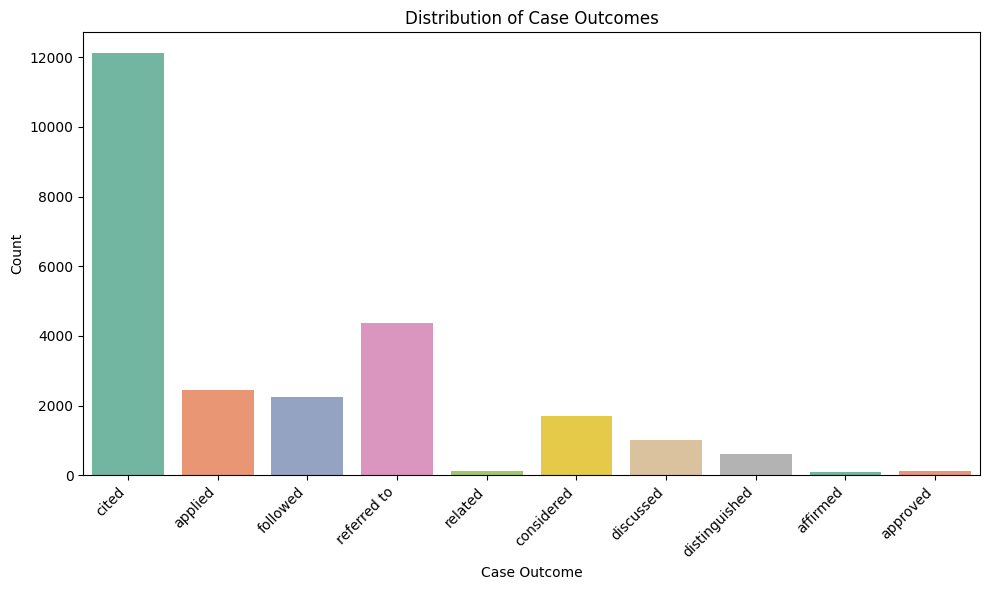

In [42]:
# Visualize the Case_Outcome distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=text_data, x='case_outcome', palette='Set2')
plt.title('Distribution of Case Outcomes')
plt.xlabel('Case Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The number of case outcomes shows that **"cited"** is the most frequent outcome, with over 12,000 occurrences, indicating that legal cases cite previous cases as part of their judgments. Other regular outcomes are **"referred to"**, **"applied"**, and **"followed"**, which indicates that legal precedent plays a significant role in making judgments. Less frequent outcomes like **"related," "considered," "discussed," "distinguished," "affirmed," and "approved"** are found to have much lower frequencies, which indicate that cases are not so often explicitly distinguished or affirmed. This trend is due to the overreliance on past rulings in judicial proceedings.

In [43]:
# Identify the most frequently used words in Case_Text
# Get all the words from the 'cleaned_case_text' column
all_words = ' '.join(text_data['Cleaned_Case_Text']).split()
# all_words

In [44]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]
filtered_words[:10]

['ordinarily',
 'discretion',
 'exercised',
 'cost',
 'follow',
 'event',
 'awarded',
 'party',
 'party',
 'basis']

In [45]:
# Create a Counter object to get the 50 most common words
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(50)
most_common_words

[('v', 90180),
 ('court', 59543),
 ('ltd', 47104),
 ('j', 43951),
 ('case', 35794),
 ('act', 34985),
 ('pty', 32270),
 ('applicant', 31173),
 ('would', 27737),
 ('tribunal', 27401),
 ('decision', 25579),
 ('may', 25367),
 ('evidence', 25342),
 ('made', 24858),
 ('mr', 22762),
 ('order', 22585),
 ('per', 22133),
 ('fca', 22022),
 ('claim', 21960),
 ('party', 21867),
 ('whether', 21805),
 ('hca', 21387),
 ('clr', 21174),
 ('document', 20418),
 ('proceeding', 20401),
 ('application', 19537),
 ('see', 19367),
 ('matter', 19127),
 ('respondent', 18570),
 ('said', 18141),
 ('australia', 17963),
 ('reason', 17871),
 ('question', 17289),
 ('law', 17170),
 ('fcr', 17038),
 ('legal', 16688),
 ('also', 16446),
 ('minister', 16341),
 ('fact', 16293),
 ('purpose', 15360),
 ('issue', 15233),
 ('upon', 14510),
 ('relevant', 14285),
 ('appellant', 14248),
 ('appeal', 14246),
 ('must', 14221),
 ('person', 14181),
 ('circumstance', 13998),
 ('one', 13746),
 ('privilege', 13465)]

Clean the text

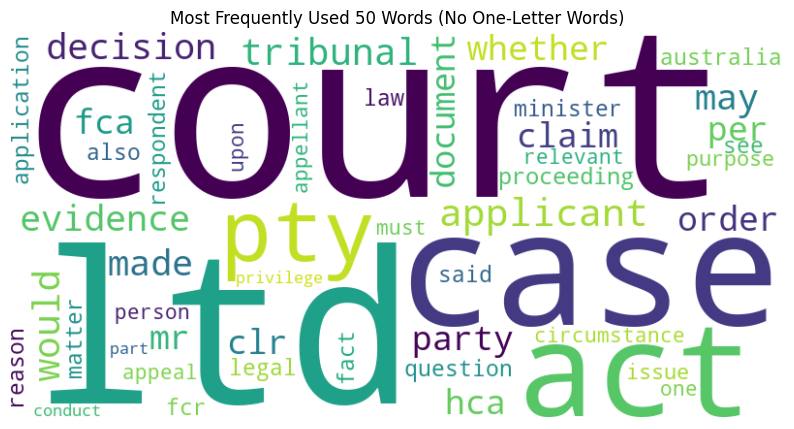

In [46]:
# Initialize Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords, lemmatize words, and remove single-letter words
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]

    # Join words back into cleaned text
    cleaned_text = " ".join(cleaned_words)

    return cleaned_text

# Apply the updated function
text_data['cleaned_case_text'] = text_data['case_text'].apply(clean_text)

# Ensure one-letter words are removed
all_words = ' '.join(text_data['cleaned_case_text']).split()

# Remove single-letter words (in case any remain)
filtered_words = [word for word in all_words if len(word) > 1]

# Count the most common words
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(50)

# Generate and display WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Used 50 Words (No One-Letter Words)')
plt.show()

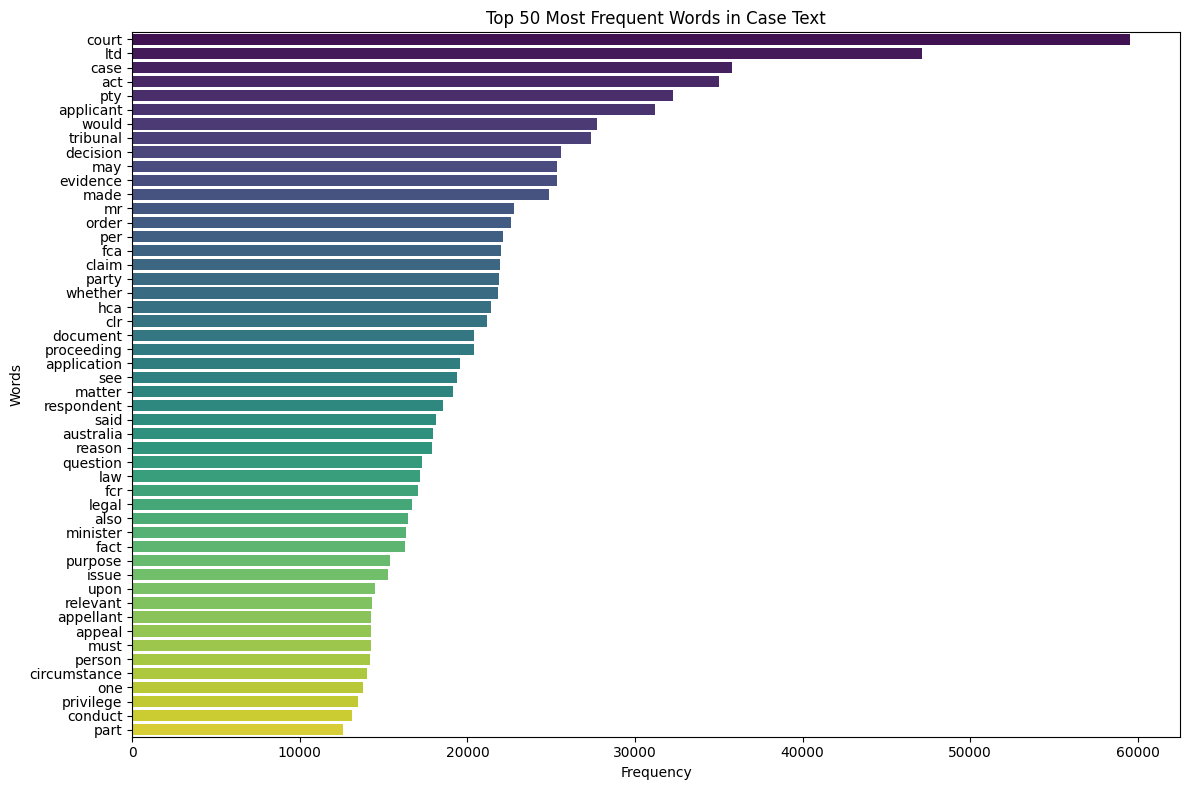

In [47]:
# Visualize top 50 most common words using a bar plot
top_50_words = dict(most_common_words)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=list(top_50_words.values()), y=list(top_50_words.keys()), palette='viridis')
plt.title('Top 50 Most Frequent Words in Case Text')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()